In [51]:
from stream2segment.process.math.ndarrays import triangsmooth
from stream2segment.process.math.traces import ampratio, bandpass, cumsumsq,\
    timeswhere, fft, maxabs, utcdatetime, ampspec, powspec, timeof, sn_split
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing as kos
from obspy import UTCDateTime
import numpy as np

def is_accelerometer(segment):
    # we might use channel code but we want to call _is_accelerometer:
    return _is_accelerometer(segment.channel.channel)


def _is_accelerometer(channel_code):
    return channel_code[1:2].lower() in ('n', 'l', 'g')

def _bandpass_remresp(segment, config, trace, inventory):
    """Applies a pre-process on the given segment waveform by
    filtering the signal and removing the instrumental response.
    DOES modify the segment stream in-place (see below)

    The filter algorithm has the following steps:
    1. Sets the max frequency to 0.9 of the Nyquist frequency (sampling rate /2)
    (slightly less than Nyquist seems to avoid artifacts)
    2. Offset removal (subtract the mean from the signal)
    3. Tapering
    . Pad data with zeros at the END in order to accommodate the filter transient
nf['bandpass_freq_max']
    5. Apply bandpass filter, where the lower frequency is set according to the magnitude
    6. Remove padded elements
    7. Remove the instrumental response

    IMPORTANT NOTES:
    - Being decorated with '@gui.preprocess', this function:
      * returns the *base* stream used by all plots whenever the relative check-box is on
      * must return either a Trace or Stream object

    - In this implementation THIS FUNCTION DOES MODIFY `segment.stream()` IN-PLACE: from within
      `main`, further calls to `segment.stream()` will return the stream returned by this function.
      However, In any case, you can use `segment.stream().copy()` before this call to keep the
      old "raw" stream

    :return: a Trace object.
    """
    # define some parameters:
    evt = segment.event
    conf = config['preprocess']
    freq_max = conf['bandpass_freq_max']
    if is_accelerometer(segment):
        # accelerometer
        freq_min = mag2freq(evt.magnitude)
    else:
        # velocimeter
        freq_min = conf['velocimeter_freq_min']

    # note: bandpass here below copied the trace! important!
    trace = bandpass(trace, freq_min=freq_min, freq_max=freq_max,
                     max_nyquist_ratio=conf['bandpass_max_nyquist_ratio'],
                     corners=conf['bandpass_corners'], copy=False)
    trace.remove_response(inventory=inventory, output=conf['remove_response_output'],
                          water_level=conf['remove_response_water_level'])
    return trace

def _sn_spectra(segment, config, ko):
    """
    Computes the signal and noise spectra, as dict of strings mapped to tuples (x0, dx, y).
    Does not modify the segment's stream or traces in-place

    -Being decorated with '@gui.sideplot' or '@gui.customplot', this function must return
     a numeric sequence y taken at successive equally spaced points in any of these forms:
        - a Trace object
        - a Stream object
        - the tuple (x0, dx, y) or (x0, dx, y, label), where
            - x0 (numeric, `datetime` or `UTCDateTime`) is the abscissa of the first point
            - dx (numeric or `timedelta`) is the sampling period
            - y (numpy array or numeric list) are the sequence values
            - label (string, optional) is the sequence name to be displayed on the plot legend.
              (if x0 is numeric and `dx` is a `timedelta` object, then x0 will be converted
              to `UTCDateTime(x0)`; if x0 is a `datetime` or `UTCDateTime` object and `dx` is
              numeric, then `dx` will be converted to `timedelta(seconds=dx)`)
        - a dict of any of the above types, where the keys (string) will denote each sequence
          name to be displayed on the plot legend.

    :return: a dict with two keys, 'Signal' and 'Noise', mapped respectively to the tuples
    (f0, df, frequencies)

    :raise: an Exception if `segment.stream()` is empty or has more than one trace (possible
    gaps/overlaps)
    """
    arrival_time = UTCDateTime(segment.arrival_time) + config['sn_windows']['arrival_time_shift']
    strace, ntrace = sn_split(segment.stream()[0],  # assumes stream has only one trace
                              arrival_time, config['sn_windows']['signal_window'])
    x0_sig, df_sig, sig = _spectrum(strace, config, ko)
    x0_noi, df_noi, noi = _spectrum(ntrace, config, ko)
    return {'Signal': (x0_sig, df_sig, sig), 'Noise': (x0_noi, df_noi, noi)}


def _spectrum(trace, config, ko):
    '''Calculate the spectrum of a trace. Returns the tuple (0, df, values), where
    values depends on the config dict parameters.
    Does not modify the trace in-place
    '''
    taper_max_percentage = config['sn_spectra']['taper']['max_percentage']
    taper_type = config['sn_spectra']['taper']['type']
    if config['sn_spectra']['type'] == 'pow':
        func = powspec  # copies the trace if needed
    elif config['sn_spectra']['type'] == 'amp':
        func = ampspec  # copies the trace if needed
    else:
        # raise TypeError so that if called from within main, the iteration stops
        raise TypeError("config['sn_spectra']['type'] expects either 'pow' or 'amp'")

    df_, spec_ = func(trace,
                      taper_max_percentage=taper_max_percentage, taper_type=taper_type)

    # if you want to implement your own smoothing, change the lines below before 'return'
    # and implement your own config variables, if any
    if ko is False:
        smoothing_wlen_ratio = config['sn_spectra']['smoothing_wlen_ratio']
        if smoothing_wlen_ratio > 0:
            spec_ = triangsmooth(spec_, winlen_ratio=smoothing_wlen_ratio)
    else:
        spec_ = kos(spec_, df_ * np.arange(0, len(spec_)))
    return (0, df_, spec_)

In [52]:
import os, yaml
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dbpath_old = jnconfig['dbpath_old']
dbpath_new = jnconfig['dbpath_new']

In [53]:
from stream2segment.process.db import get_session, Segment
import time

sess = get_session(dbpath_new)
config = {
    'sn_spectra': {
        'taper': {
            'max_percentage': 0.05,
            'type': 'hann'
        },
        'smoothing_wlen_ratio': 0.05,  # 0 for no smoothing
        'type': 'amp'  # if 'pow', then power spectra are computed, otherwise if 'amp', amplitude spectra are computed
    },
    # settings for the pre-process function implemented in the associated python module
    'preprocess': {
        'remove_response_water_level': 60,
        'remove_response_output': 'ACC',
        'bandpass_freq_max': 30,  # the max frequency, in Hz:
        'bandpass_max_nyquist_ratio': 0.9,
        'bandpass_corners': 2,
        'velocimeter_freq_min': 0.01
    },
    'sn_windows': {
        'arrival_time_shift': 0,  # programmatically shifts the arrival time for every segment (in seconds)
        'signal_window': [0.1, 0.9]  # either a number (in seconds) or interval relative to the % of the cumulative
    }
}

traces = {}

time_t = []
time_ko = []

try:
    for segment in sess.query(Segment).filter((Segment.has_data == True) & (Segment.maxgap_numsamples.in_([-0.4, 0.4]))).limit(5).all():
        trace = _bandpass_remresp(segment, config, segment.stream()[0], segment.inventory())
        traces[segment.id] = {}
        t = time.time()
        spectra = _sn_spectra(segment, config, False)
        time_t.append(time.time() -t)
        sig = spectra['Signal']
        traces[segment.id]['trismooth'] = spectra['Signal']
        t = time.time()
        spectra_ko = _sn_spectra(segment, config, True)
        time_ko.append(time.time() -t)
        sig = spectra_ko['Signal']
        traces[segment.id]['ko'] = spectra['Signal']
        # traces.append([[spectra[0], spectra_ko[0]], [spectra[1], spectra_ko[1]]])
finally:
    sess.close()

print("trismooth: %f, %f, %f" % (np.min(time_t), np.quantile(time_t, 0.5), np.max(time_t)))
print("ko: %f, %f, %f" % (np.min(time_ko), np.quantile(time_ko, 0.5), np.max(time_ko)))

trismooth: 0.020523, 0.025583, 0.058186
ko: 1.721070, 2.128141, 2.364026


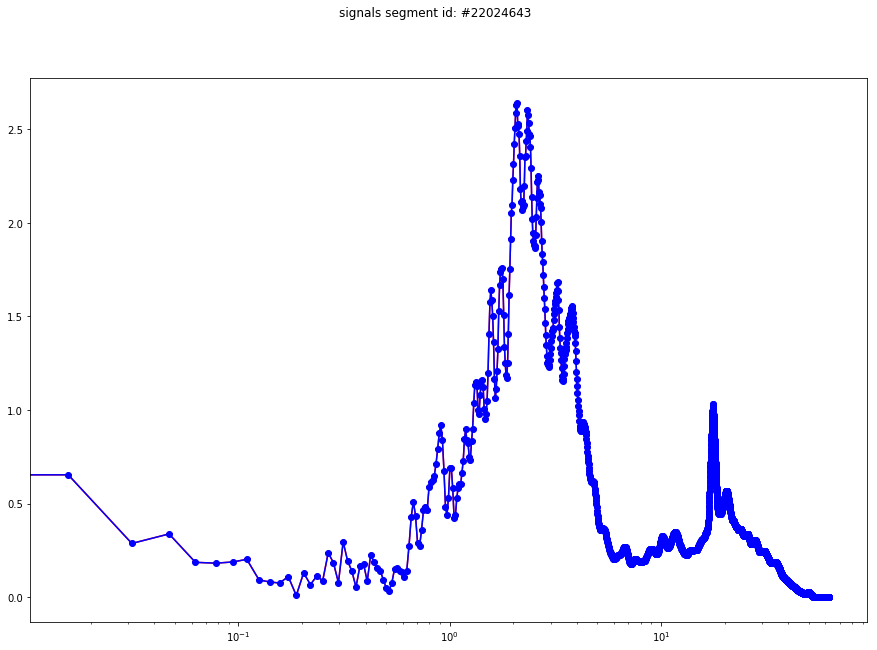

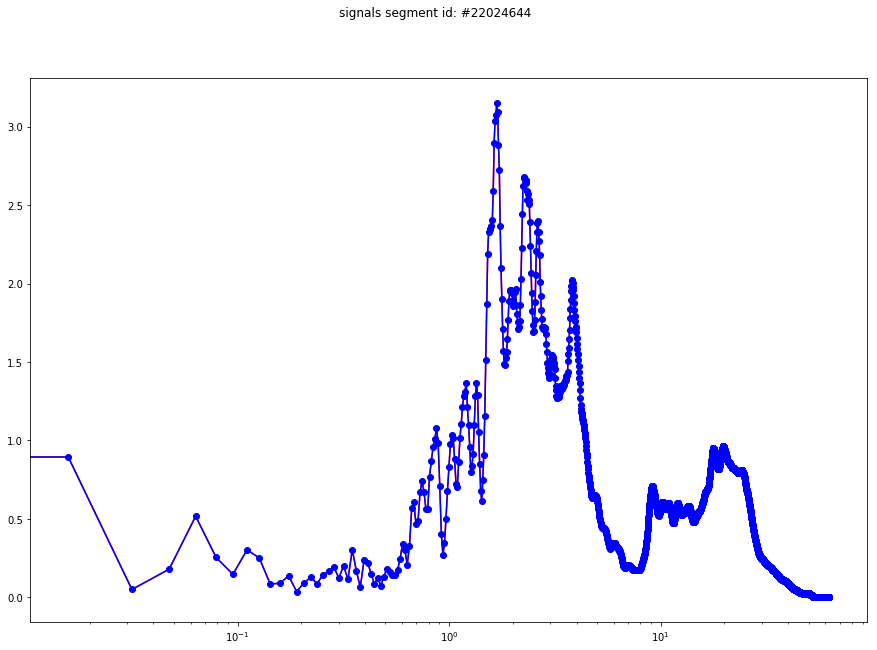

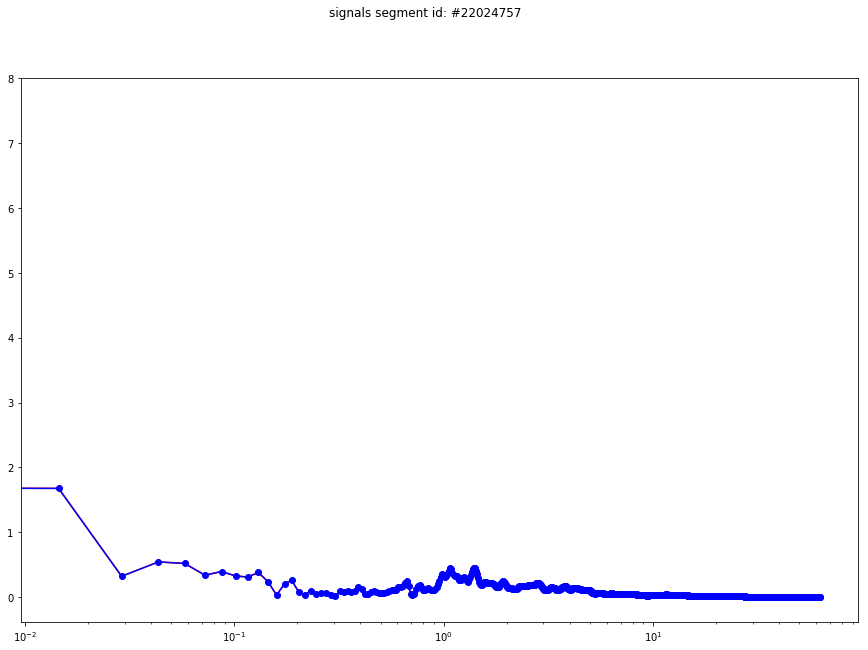

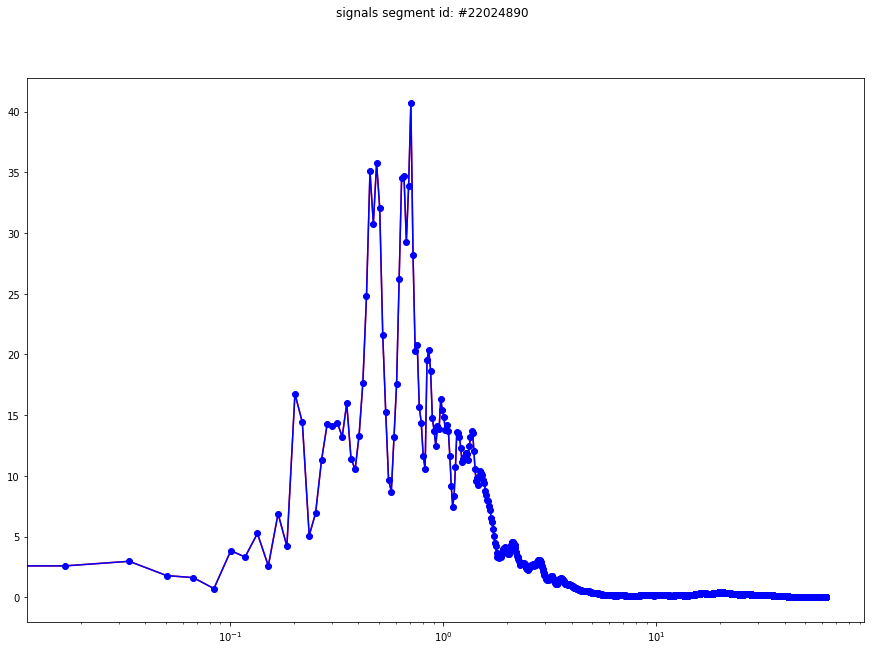

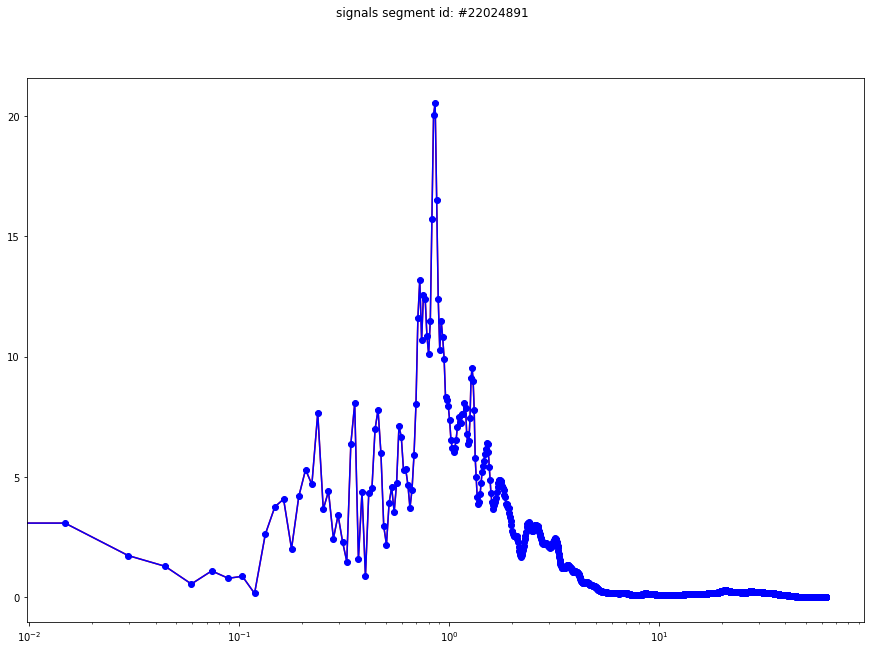

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

i = 1
for id, data in traces.items():
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes()
    _, df, y = data['trismooth']
    # print(data['trismooth'])
    ax.semilogx(df*np.arange(len(y)), y, color='red', marker='*')
    _, df, y = data['ko']
    ax = plt.axes()
    ax.semilogx(df*np.arange(len(y)), y, color='blue', marker='o')
    fig.suptitle('signals segment id: #%d' % id)
    plt.show()

#     fig = plt.figure(figsize=(15, 10))
#     fig.plot(signals)
#     fig.suptitle('noise segment #%d' % i, color='r')
#     plt.show()

    i += 1